In [1]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import OneHotEncoder



Each image is presented as a reshaped 1D vector version of the image, next to the corresponding label in the "label" column.

Each image is labeled with a number, from 0 to 24 


Note:   
    
    (numbers 9 and 25 are skipped, corresponding to the letters "j" and "z", respectively)

In [2]:
# A simple mapping relating the label with its corresponding letter
mapping_dict = {}
value = 0
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    if letter in ["J","Z"]:
        value += 1
        continue
    mapping_dict[letter] = value
    value += 1
inverted_dict = {v:k for k,v in mapping_dict.items()} 

In [3]:
train_df = pd.read_csv("datasets/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("datasets/sign_mnist_test/sign_mnist_test.csv")

display("train_df: ",train_df.sample(5))

y_train = train_df[['label']]
y_test = test_df[['label']]
del train_df['label']
del test_df['label']

print("Labels: ",y_train.label.sort_values().unique())

'train_df: '

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
23368,21,134,139,146,149,151,156,158,159,163,...,171,151,104,111,205,203,204,204,205,204
13519,0,147,148,149,151,152,152,151,152,153,...,170,163,164,163,163,166,165,134,136,140
14798,23,202,203,204,204,205,205,205,203,203,...,235,234,234,234,233,232,233,233,231,230
7699,13,196,196,197,197,196,196,196,196,195,...,46,43,38,27,22,29,22,25,33,15
11709,21,149,152,155,159,161,163,166,167,168,...,205,205,204,204,204,204,200,199,193,174


Labels:  [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


From the rounding 35000 of samples in total, 20% correspond to the training set, which seems appropriate

In [4]:
num_test = y_test.shape[0]
num_train = y_train.shape[0]

num_tot = num_test+num_train
print(f"Total number of samples: {num_tot}")
print(f"percentage of test samples: {100*num_test/num_tot:.2f}%")

Total number of samples: 34627
percentage of test samples: 20.71%


Categories seem balanced for both training and test sets

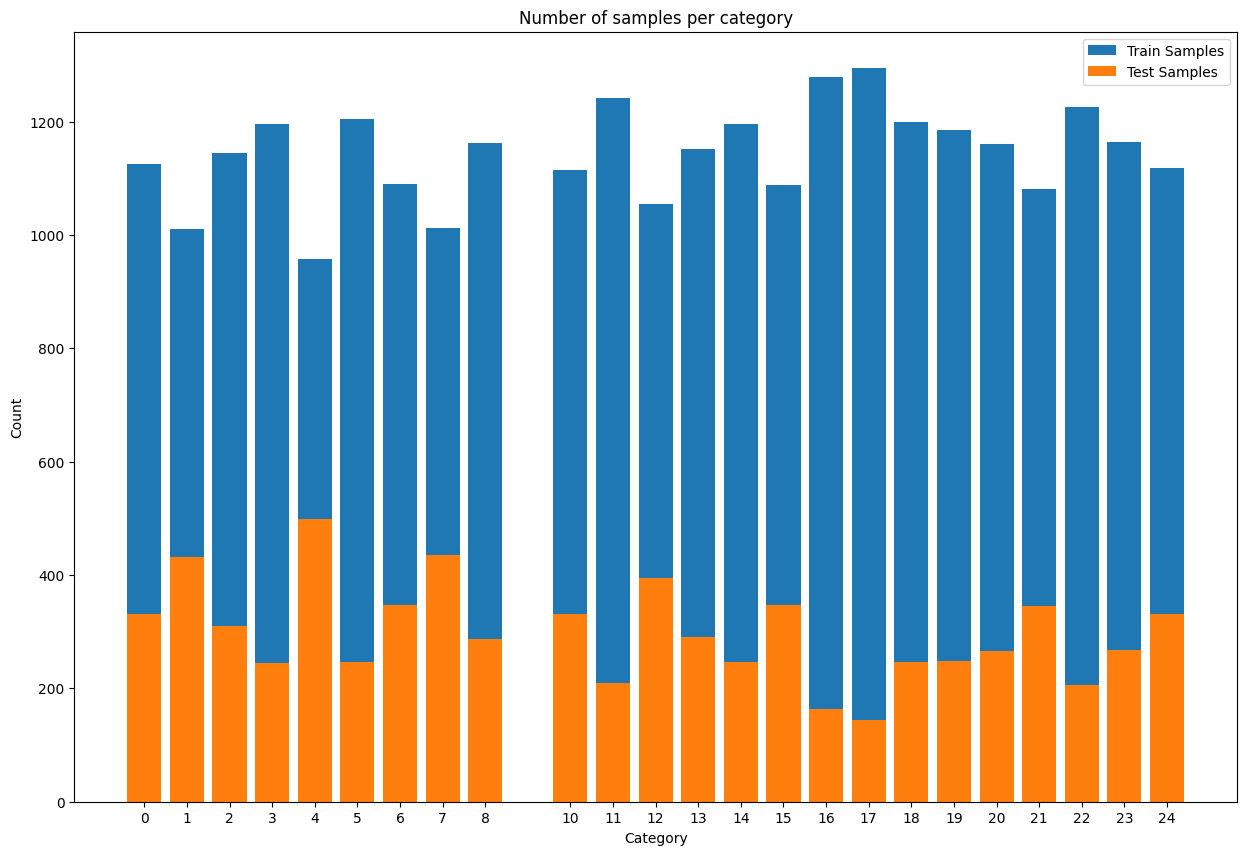

In [5]:
y_labels = y_train.label.unique()
bins = len(y_labels)

plt.figure(figsize=(15, 10))

train_label_counts = y_train.label.value_counts()
plt.bar(train_label_counts.index, train_label_counts.values, label='Train Samples')
test_label_counts = y_test.label.value_counts()
plt.bar(test_label_counts.index, test_label_counts.values, label='Test Samples')

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of samples per category')
plt.xticks(sorted(y_labels))
plt.legend()

plt.show()


In [6]:
# Preprocessing image data (each is a 28x28 pixel image)

x_train = train_df.values
x_test = test_df.values
# Normalize
x_train_norm = x_train / 255
x_test_norm = x_test / 255
# Reshape
num_pixels = int((train_df.shape[1])**(1/2))
x_train_norm = x_train_norm.reshape(-1,num_pixels,num_pixels,1)
x_test_norm = x_test_norm.reshape(-1,num_pixels,num_pixels,1)

Checking some of the images and its corresponding labels 

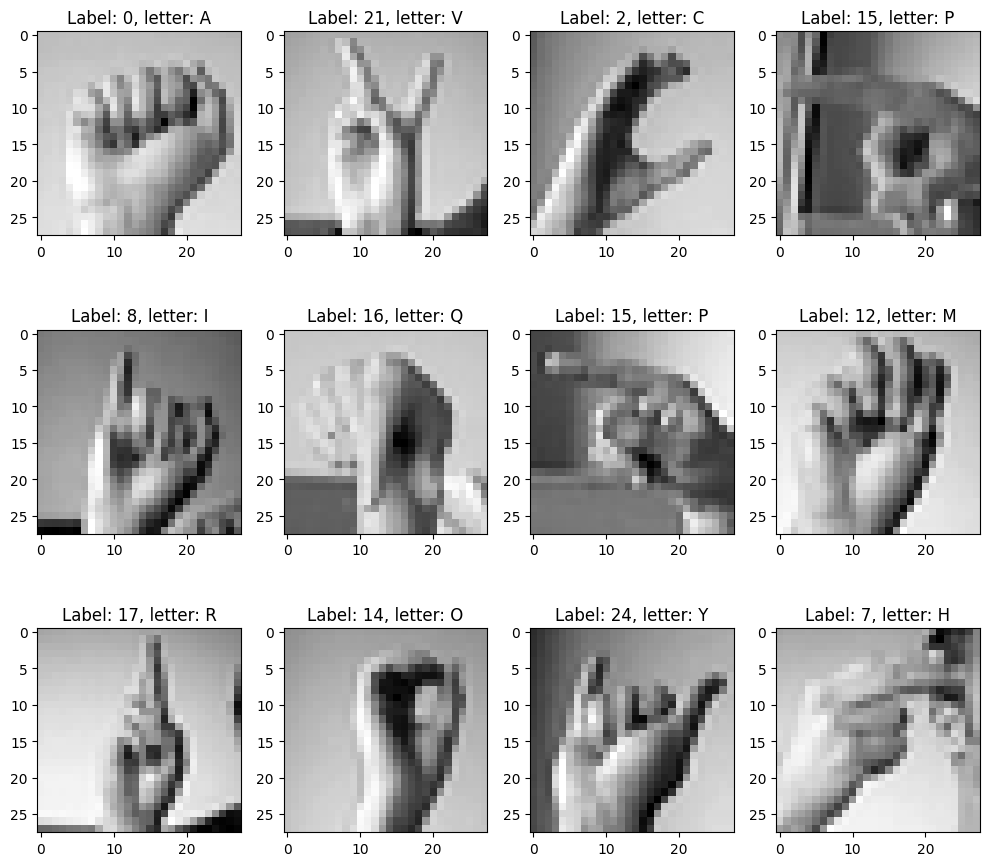

In [7]:
check_on = x_train_norm
label_on = y_train.values
n_rows = 3
n_cols = 4

f, ax = plt.subplots(n_rows,n_cols) 
f.set_size_inches(10, 10)
for i in range(n_rows):
    for j in range(n_cols):
        im_idx = random.randint(0,check_on.shape[0])
        label = label_on[im_idx][0]
        ax[i,j].imshow(check_on[im_idx].reshape(28, 28) , cmap = "gray")
        ax[i,j].set_title(f"Label: {label}, letter: {inverted_dict[label]}")
    plt.tight_layout()   

In [8]:
# OUTPUT ENCODING

oh_encoder = OneHotEncoder()

y_train_oh = oh_encoder.fit_transform(y_train)
display(y_train_oh.toarray())
y_test_oh = oh_encoder.fit_transform(y_test)
display(y_test_oh.toarray())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [9]:

inverted_dict[9]

KeyError: 9